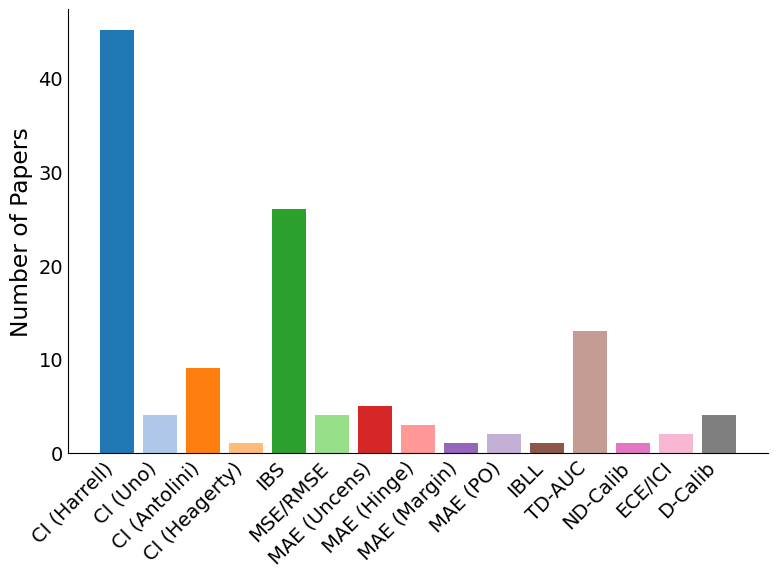

In [49]:
import pandas as pd
import seaborn as sns

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',  # Set larger title size
    'font.size': 14.0,
    'legend.fontsize': 'medium'
})

# Load data
df = pd.read_csv('data.csv')

# Count non-empty values per metric (excluding the title column)
metric_counts = df.iloc[:, 1:].apply(lambda col: col.notna() & (col != ''), axis=0).sum()

# Plot
plt.figure(figsize=(8, 6))

colors = plt.cm.tab20.colors[:len(metric_counts)]  # matplotlib colors
bars = plt.bar(metric_counts.index, metric_counts.values, color=colors)

# Add legend without border
for bar, label in zip(bars, metric_counts.index):
    bar.set_label(label)

#legend = plt.legend(title="Metric", loc='upper right', frameon=False)

# Remove top and right plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Clean ticks
plt.tick_params(axis='y', which='both', length=0)
plt.tick_params(axis='x', which='both', length=0)

# Axis labels and title
plt.ylabel("Number of Papers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

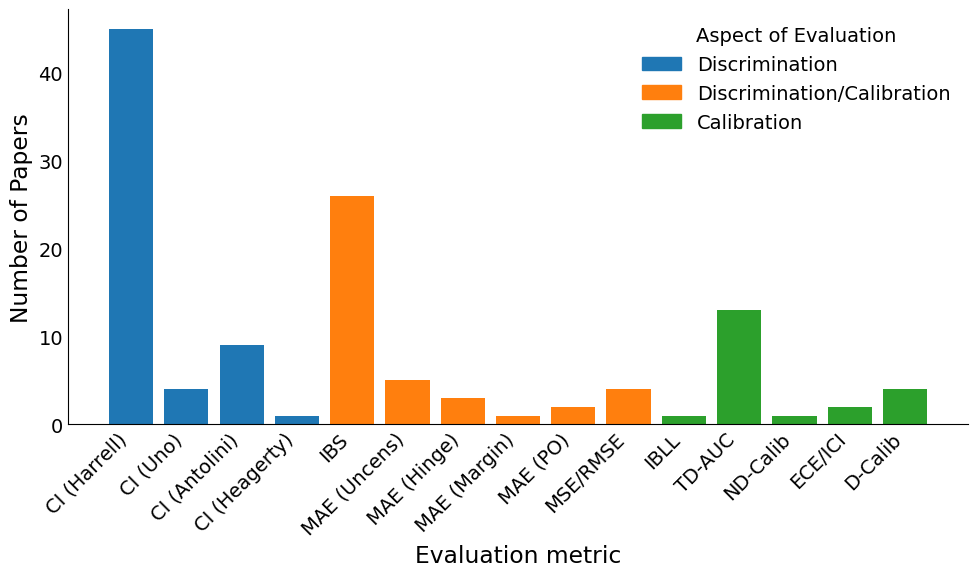

In [56]:
# Example: assuming `metric_counts` is a Pandas Series
# with metric names as index and count as values

# Define categories
categories = {
    "Discrimination": ["CI (Harrell)", "CI (Uno)", "CI (Antolini)", "CI (Heagerty)"],
    "Discrimination/Calibration": ["IBS", "MAE (Uncens)", "MAE (Hinge)", "MAE (Margin)", "MAE (PO)", "MSE/RMSE"],
    "Calibration": ["IBLL", "TD-AUC", "ND-Calib", "ECE/ICI", "D-Calib"]
}

# Define category colors
category_colors = {
    "Discrimination": "tab:blue",
    "Discrimination/Calibration": "tab:orange",
    "Calibration": "tab:green"
}

# Flatten to map each metric to its category and color
metric_to_category = {metric: cat for cat, metrics in categories.items() for metric in metrics}
metric_to_color = {metric: category_colors[metric_to_category[metric]] for metric in metric_counts.index}

# Sort metrics by category for grouped plotting
sorted_metrics = sum(categories.values(), [])

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    sorted_metrics,
    [metric_counts.get(m, 0) for m in sorted_metrics],
    color=[metric_to_color.get(m, "gray") for m in sorted_metrics]
)

# Remove plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend handles (category color blocks)
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=cat) for cat, color in category_colors.items()]
plt.legend(handles=legend_handles, title="Aspect of Evaluation", frameon=False)

# Labeling
plt.ylabel("Number of Papers")
plt.xlabel("Evaluation metric")
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0)
plt.tight_layout()
plt.show()